In [1]:
# Kaggle Notebook: EASY TASK (Audio-only) ✅
# - GTZAN audio -> MFCC features
# - PCA + KMeans baseline + metrics
# - Basic VAE (MLP) -> latent vectors
# - KMeans on latent + metrics
# - t-SNE visualization

# =========================
# 0) Imports & setup
# =========================
import os, glob, math, random
import numpy as np
import pandas as pd

import librosa
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


In [2]:
# =========================
# 1) Locate GTZAN dataset (Kaggle input)
# =========================
# Kaggle input path typically:
# /kaggle/input/gtzan-dataset-music-genre-classification/
# Inside you usually have:
# - Data/genres_original/<genre>/*.wav
# (Sometimes it could be "genres_original" directly.)

ROOT = "/kaggle/input/gtzan-dataset-music-genre-classification"

# Try common folders
candidate_patterns = [
    os.path.join(ROOT, "Data", "genres_original", "*", "*.wav"),
    os.path.join(ROOT, "genres_original", "*", "*.wav"),
    os.path.join(ROOT, "*", "*", "*.wav"),
]

wav_files = []
for pat in candidate_patterns:
    found = glob.glob(pat)
    if len(found) > 0:
        wav_files = found
        print("Found wavs using pattern:", pat)
        break

if not wav_files:
    raise FileNotFoundError(
        "Could not find wav files. Check dataset folder structure under /kaggle/input."
    )

print("Total wav files found:", len(wav_files))
print("Example:", wav_files[0])


Found wavs using pattern: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/*/*.wav
Total wav files found: 1000
Example: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav


In [3]:
# =========================
# 2) Feature extraction (MFCC mean+std pooling)
# =========================
# Easy-task friendly: vector features per track.
# We'll extract MFCCs and summarize across time using mean+std -> fixed length.

SR = 22050           # target sample rate
DURATION = 30.0      # seconds (GTZAN clips are ~30s)
N_MFCC = 20

def extract_mfcc_features(path, sr=SR, duration=DURATION, n_mfcc=N_MFCC):
    y, _sr = librosa.load(path, sr=sr, mono=True, duration=duration)
    # If shorter, pad
    target_len = int(sr * duration)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # summarize across time frames
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_std  = mfcc.std(axis=1)
    feat = np.concatenate([mfcc_mean, mfcc_std], axis=0)  # 2*n_mfcc
    return feat.astype(np.float32)

def parse_genre_from_path(path):
    # works for .../genres_original/<genre>/file.wav
    parts = path.replace("\\", "/").split("/")
    # find genre by looking for folder right before filename
    return parts[-2]

# Extract all features
X = []
genres = []
paths_kept = []

for i, p in enumerate(wav_files):
    try:
        feat = extract_mfcc_features(p)
        X.append(feat)
        genres.append(parse_genre_from_path(p))
        paths_kept.append(p)
    except Exception as e:
        # skip problematic files
        print("Skipping:", p, "Error:", str(e))

X = np.vstack(X)
genres = np.array(genres)
print("Feature matrix shape:", X.shape)
print("Unique genres:", sorted(set(genres)))


/tmp/ipykernel_24/741935584.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _sr = librosa.load(path, sr=sr, mono=True, duration=duration)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav Error: 
Feature matrix shape: (999, 40)
Unique genres: [np.str_('blues'), np.str_('classical'), np.str_('country'), np.str_('disco'), np.str_('hiphop'), np.str_('jazz'), np.str_('metal'), np.str_('pop'), np.str_('reggae'), np.str_('rock')]


In [4]:
# =========================
# 3) Standardize features
# =========================
scaler = StandardScaler()
Xz = scaler.fit_transform(X)
print("Xz mean/std:", Xz.mean().round(4), Xz.std().round(4))


Xz mean/std: -0.0 1.0


In [5]:
# =========================
# 4) PCA + KMeans baseline + metrics (Easy requirement)
# =========================
# Choose number of clusters K.
# For GTZAN there are 10 genres, but we are UNSUPERVISED.
# Still, K=10 is a reasonable choice for evaluation.

K = 10

pca = PCA(n_components=10, random_state=SEED)
Xp = pca.fit_transform(Xz)

kmeans_pca = KMeans(n_clusters=K, n_init=10, random_state=SEED)
labels_pca = kmeans_pca.fit_predict(Xp)

sil_pca = silhouette_score(Xp, labels_pca)
ch_pca  = calinski_harabasz_score(Xp, labels_pca)

print("PCA+KMeans baseline")
print(" Silhouette:", round(sil_pca, 4))
print(" Calinski-Harabasz:", round(ch_pca, 2))


PCA+KMeans baseline
 Silhouette: 0.1876
 Calinski-Harabasz: 182.54


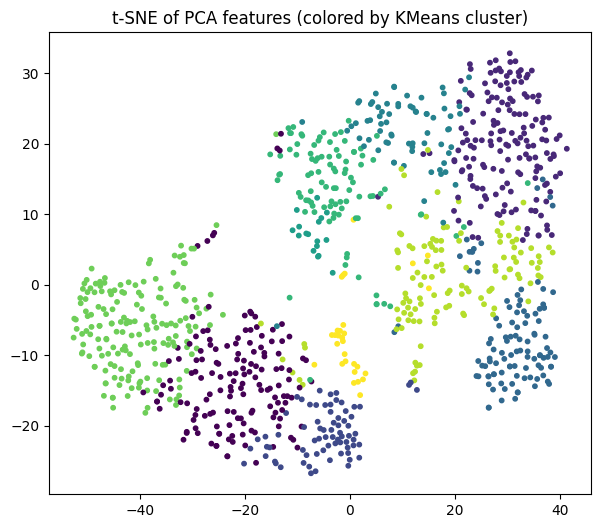

In [6]:
# Optional: visualize PCA baseline using t-SNE for clusters
tsne_pca = TSNE(n_components=2, perplexity=30, init="pca", random_state=SEED, learning_rate="auto")
Xp_2d = tsne_pca.fit_transform(Xp)

plt.figure(figsize=(7,6))
plt.scatter(Xp_2d[:,0], Xp_2d[:,1], c=labels_pca, s=10)
plt.title("t-SNE of PCA features (colored by KMeans cluster)")
plt.show()


In [7]:
# =========================
# 5) Build a simple VAE (MLP) for EASY task
# =========================
INPUT_DIM = Xz.shape[1]      # 40 if N_MFCC=20 -> mean+std = 40
HIDDEN_DIM = 128
LATENT_DIM = 8

class VAETwitter(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.enc(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterize(mu, logvar)
        x_hat = self.dec(z)
        return x_hat, mu, logvar

def vae_loss(x, x_hat, mu, logvar):
    # Reconstruction: MSE on standardized features
    recon = torch.mean((x - x_hat) ** 2)
    # KL divergence
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kld, recon.detach(), kld.detach()


In [8]:
# =========================
# 6) Dataloader
# =========================
class NumpyDataset(Dataset):
    def __init__(self, arr):
        self.arr = torch.tensor(arr, dtype=torch.float32)
    def __len__(self):
        return self.arr.shape[0]
    def __getitem__(self, idx):
        return self.arr[idx]

# Shuffle split (unsupervised but helps check overfitting)
N = Xz.shape[0]
idx = np.arange(N)
np.random.shuffle(idx)

split = int(0.9 * N)
train_idx, val_idx = idx[:split], idx[split:]
X_train, X_val = Xz[train_idx], Xz[val_idx]

train_loader = DataLoader(NumpyDataset(X_train), batch_size=64, shuffle=True, drop_last=False)
val_loader   = DataLoader(NumpyDataset(X_val), batch_size=64, shuffle=False, drop_last=False)

print("Train/Val:", X_train.shape, X_val.shape)


Train/Val: (899, 40) (100, 40)


Epoch 01 | Train loss 1.0090 (recon 1.0056, kld 0.0034) | Val loss 1.0360 (recon 1.0341, kld 0.0019)
Epoch 05 | Train loss 0.9727 (recon 0.9445, kld 0.0281) | Val loss 0.9786 (recon 0.9152, kld 0.0635)
Epoch 10 | Train loss 0.8864 (recon 0.7913, kld 0.0951) | Val loss 0.9335 (recon 0.8295, kld 0.1039)
Epoch 15 | Train loss 0.8303 (recon 0.7010, kld 0.1294) | Val loss 0.8571 (recon 0.7288, kld 0.1282)
Epoch 20 | Train loss 0.8217 (recon 0.6804, kld 0.1413) | Val loss 0.8477 (recon 0.7019, kld 0.1458)
Epoch 25 | Train loss 0.8045 (recon 0.6474, kld 0.1570) | Val loss 0.8309 (recon 0.6517, kld 0.1792)
Epoch 30 | Train loss 0.8142 (recon 0.6425, kld 0.1717) | Val loss 0.8341 (recon 0.6472, kld 0.1869)
Epoch 35 | Train loss 0.7928 (recon 0.6218, kld 0.1710) | Val loss 0.8115 (recon 0.6278, kld 0.1837)
Epoch 40 | Train loss 0.7938 (recon 0.6173, kld 0.1766) | Val loss 0.8383 (recon 0.6632, kld 0.1752)
Epoch 45 | Train loss 0.7862 (recon 0.6185, kld 0.1677) | Val loss 0.8399 (recon 0.6707, kl

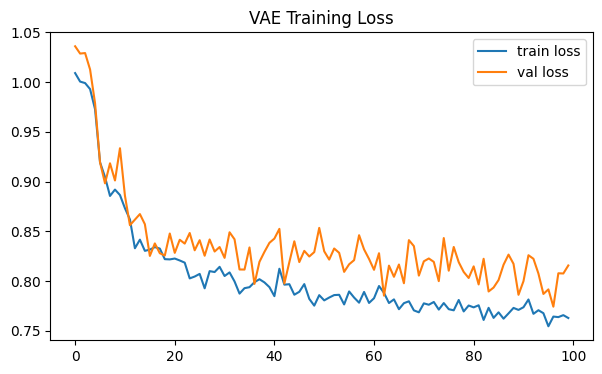

In [9]:
# =========================
# 7) Train VAE
# =========================
vae = VAETwitter().to(DEVICE)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

EPOCHS = 100

train_hist = []
val_hist = []

for epoch in range(1, EPOCHS + 1):
    vae.train()
    tr_loss = tr_recon = tr_kld = 0.0
    n_tr = 0

    for xb in train_loader:
        xb = xb.to(DEVICE)
        opt.zero_grad()
        xhat, mu, logvar = vae(xb)
        loss, recon, kld = vae_loss(xb, xhat, mu, logvar)
        loss.backward()
        opt.step()

        bs = xb.size(0)
        tr_loss += loss.item() * bs
        tr_recon += recon.item() * bs
        tr_kld += kld.item() * bs
        n_tr += bs

    vae.eval()
    va_loss = va_recon = va_kld = 0.0
    n_va = 0
    with torch.no_grad():
        for xb in val_loader:
            xb = xb.to(DEVICE)
            xhat, mu, logvar = vae(xb)
            loss, recon, kld = vae_loss(xb, xhat, mu, logvar)
            bs = xb.size(0)
            va_loss += loss.item() * bs
            va_recon += recon.item() * bs
            va_kld += kld.item() * bs
            n_va += bs

    tr_loss /= n_tr; tr_recon /= n_tr; tr_kld /= n_tr
    va_loss /= n_va; va_recon /= n_va; va_kld /= n_va

    train_hist.append((tr_loss, tr_recon, tr_kld))
    val_hist.append((va_loss, va_recon, va_kld))

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Train loss {tr_loss:.4f} (recon {tr_recon:.4f}, kld {tr_kld:.4f}) "
              f"| Val loss {va_loss:.4f} (recon {va_recon:.4f}, kld {va_kld:.4f})")

# Plot training curve
train_hist = np.array(train_hist)
val_hist = np.array(val_hist)

plt.figure(figsize=(7,4))
plt.plot(train_hist[:,0], label="train loss")
plt.plot(val_hist[:,0], label="val loss")
plt.title("VAE Training Loss")
plt.legend()
plt.show()


In [10]:
# =========================
# 8) Extract latent vectors (use mu) for clustering
# =========================
vae.eval()
with torch.no_grad():
    X_tensor = torch.tensor(Xz, dtype=torch.float32).to(DEVICE)
    h = vae.enc(X_tensor)
    Z_mu = vae.mu(h).cpu().numpy()

print("Latent shape:", Z_mu.shape)


Latent shape: (999, 8)


In [11]:
# =========================
# 9) KMeans on latent + metrics (Easy requirement)
# =========================
kmeans_latent = KMeans(n_clusters=K, n_init=10, random_state=SEED)
labels_latent = kmeans_latent.fit_predict(Z_mu)

sil_latent = silhouette_score(Z_mu, labels_latent)
ch_latent  = calinski_harabasz_score(Z_mu, labels_latent)

print("VAE(latent mu)+KMeans")
print(" Silhouette:", round(sil_latent, 4))
print(" Calinski-Harabasz:", round(ch_latent, 2))

# Save metrics for your report
metrics = pd.DataFrame([
    {"method":"PCA(10)+KMeans", "K":K, "silhouette":sil_pca, "calinski_harabasz":ch_pca},
    {"method":"VAE(latent_mu)+KMeans", "K":K, "silhouette":sil_latent, "calinski_harabasz":ch_latent},
])
metrics


VAE(latent mu)+KMeans
 Silhouette: 0.3406
 Calinski-Harabasz: 464.39


method   K  silhouette  calinski_harabasz
0         PCA(10)+KMeans  10    0.187615         182.540619
1  VAE(latent_mu)+KMeans  10    0.340639         464.393890

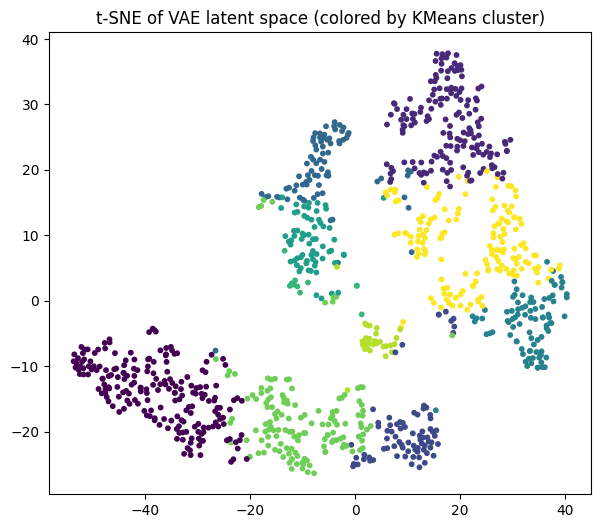

In [12]:
# =========================
# 10) t-SNE visualization of latent clusters (Easy requirement)
# =========================
tsne = TSNE(n_components=2, perplexity=30, init="pca", random_state=SEED, learning_rate="auto")
Z_2d = tsne.fit_transform(Z_mu)

plt.figure(figsize=(7,6))
plt.scatter(Z_2d[:,0], Z_2d[:,1], c=labels_latent, s=10)
plt.title("t-SNE of VAE latent space (colored by KMeans cluster)")
plt.show()


In [13]:
# =========================
# 11) (Optional) Quick sanity: cluster composition by true GTZAN genre
# NOTE: This is NOT used for training; only for qualitative inspection.
# =========================
df_debug = pd.DataFrame({
    "path": paths_kept,
    "genre_true": genres,
    "cluster_pca": labels_pca,
    "cluster_latent": labels_latent
})

# Show dominant true genre in each latent cluster
summary = (
    df_debug.groupby("cluster_latent")["genre_true"]
    .value_counts(normalize=False)
    .groupby(level=0)
    .head(3)
    .reset_index(name="count")
)
summary


cluster_latent genre_true  count
0                0      metal     87
1                0       rock     33
2                0      blues     28
3                1      disco     31
4                1       rock     28
5                1    country     24
6                2     reggae     30
7                2     hiphop     18
8                2      blues      9
9                3  classical     43
10               3       jazz     27
11               3    country      4
12               4        pop     33
13               4     reggae     27
14               4     hiphop     21
15               5  classical     42
16               5       jazz     16
17               5    country      3
18               6  classical      4
19               6        pop      4
20               6       jazz      3
21               7      blues     26
22               7    country     26
23               7       rock     24
24               8      blues     16
25               8    country      7
26               8     reggae      2
27               9        pop     38
28               9     hiphop     26
29               9     reggae     22

In [14]:
# =========================
# 12) Export results (optional)
# =========================
os.makedirs("results", exist_ok=True)
metrics.to_csv("results/clustering_metrics_easy.csv", index=False)
df_debug.to_csv("results/assignments_easy.csv", index=False)
print("Saved:")
print(" - results/clustering_metrics_easy.csv")
print(" - results/assignments_easy.csv")


Saved:
 - results/clustering_metrics_easy.csv
 - results/assignments_easy.csv


In [15]:
# ============================================
# Kaggle Notebook: MEDIUM TASK (Updated, Robust) ✅
# ============================================
# Medium requirements covered:
# - Convolutional VAE on audio (mel-spectrogram, GTZAN)
# - Lyrics embeddings (English + Bangla) using TF-IDF (char n-grams) + SVD (offline friendly)
# - Multiple clustering algorithms: KMeans, Agglomerative, DBSCAN
# - Metrics: Silhouette, Calinski–Harabasz, Davies–Bouldin
# - Visualizations: t-SNE plots
#
# IMPORTANT:
# - Your datasets are not paired (audio != same songs as lyrics).
# - This notebook does:
#   A) Audio-only clustering (ConvVAE latent)
#   B) Lyrics-only clustering (TF-IDF+SVD)
#   C) "Unpaired fusion": randomly pair audio and lyrics to create fused vectors (research baseline)
#
# FIXES included:
# - GTZAN contains some broken wavs. Kaggle may lack audioread backend.
# - We use a safe loader, skip bad files, and set num_workers=0 to avoid worker crashes.

# ============================================
# CELL 1: Imports & setup
# ============================================
import os, glob, random, math, warnings
import numpy as np
import pandas as pd

import librosa
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


In [16]:
# ============================================
# CELL 2: Locate datasets (Kaggle inputs)
# ============================================
GTZAN_ROOT = "/kaggle/input/gtzan-dataset-music-genre-classification"
SPOTIFY_ROOT = "/kaggle/input/spotify-million-song-dataset"
BANGLA_ROOT = "/kaggle/input/bangla-song-lyrics"

# Find GTZAN wavs
candidate_patterns = [
    os.path.join(GTZAN_ROOT, "Data", "genres_original", "*", "*.wav"),
    os.path.join(GTZAN_ROOT, "genres_original", "*", "*.wav"),
]

wav_files = []
for pat in candidate_patterns:
    found = glob.glob(pat)
    if found:
        wav_files = found
        print("GTZAN wavs found:", len(wav_files), "pattern:", pat)
        break

if not wav_files:
    raise FileNotFoundError("GTZAN wav files not found. Check /kaggle/input folder structure.")

def parse_genre_from_path(path):
    return path.replace("\\", "/").split("/")[-2]

genres = np.array([parse_genre_from_path(p) for p in wav_files])
print("GTZAN genres:", sorted(set(genres)))
print("Example wav:", wav_files[0])


GTZAN wavs found: 1000 pattern: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/*/*.wav
GTZAN genres: [np.str_('blues'), np.str_('classical'), np.str_('country'), np.str_('disco'), np.str_('hiphop'), np.str_('jazz'), np.str_('metal'), np.str_('pop'), np.str_('reggae'), np.str_('rock')]
Example wav: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav


In [17]:
# ============================================
# CELL 3: Audio preprocessing (safe loader) + mel specs
# ============================================
SR = 22050
DURATION = 30.0
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048

def audio_to_logmelspec_safe(path, sr=SR, duration=DURATION):
    # Safe loading: return None if decode fails
    try:
        y, _ = librosa.load(path, sr=sr, mono=True, duration=duration)
    except Exception:
        return None

    target_len = int(sr * duration)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]

    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, power=2.0
    )
    S_db = librosa.power_to_db(S, ref=np.max)  # (n_mels, time)
    S_db = (S_db - S_db.mean()) / (S_db.std() + 1e-8)
    return S_db.astype(np.float32)

# Determine fixed frame count from first valid file
example = None
for p in wav_files:
    example = audio_to_logmelspec_safe(p)
    if example is not None:
        break
if example is None:
    raise RuntimeError("No valid GTZAN audio files could be loaded in this environment.")

N_FRAMES = example.shape[1]
print("Example mel shape:", example.shape, "=> fixed frames:", N_FRAMES)


Example mel shape: (128, 1292) => fixed frames: 1292


In [18]:
# ============================================
# CELL 4: Filter bad GTZAN wavs up-front (recommended)
# ============================================
# This makes training faster + avoids repeated failures.
MAX_AUDIO = 1000  # keep <= 1000 for speed

idx = np.arange(len(wav_files))
np.random.shuffle(idx)
idx = idx[:min(MAX_AUDIO, len(idx))]
wav_files_sub = [wav_files[i] for i in idx]

good, bad = [], []
for p in wav_files_sub:
    S = audio_to_logmelspec_safe(p)
    if S is None:
        bad.append(p)
    else:
        good.append(p)

print("Audio subset:", len(wav_files_sub), "| Good:", len(good), "| Bad:", len(bad))
wav_files_sub = good
genres_sub = np.array([parse_genre_from_path(p) for p in wav_files_sub])

print("Using audio samples:", len(wav_files_sub))


/tmp/ipykernel_24/2928195097.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr, mono=True, duration=duration)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio subset: 1000 | Good: 999 | Bad: 1
Using audio samples: 999


In [19]:
# ============================================
# CELL 5: Safe Dataset + DataLoaders (num_workers=0)
# ============================================
class MelSpecDatasetSafe(Dataset):
    def __init__(self, paths, n_mels=N_MELS, n_frames=N_FRAMES):
        self.paths = paths
        self.n_mels = n_mels
        self.n_frames = n_frames

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        S = audio_to_logmelspec_safe(self.paths[i])
        if S is None:
            # should be rare after filtering, but keep safe
            S = np.zeros((self.n_mels, self.n_frames), dtype=np.float32)
        else:
            # ensure consistent frames by crop/pad (very rare)
            if S.shape[1] > self.n_frames:
                S = S[:, :self.n_frames]
            elif S.shape[1] < self.n_frames:
                S = np.pad(S, ((0,0),(0, self.n_frames - S.shape[1])))

        return torch.tensor(S).unsqueeze(0)  # (1, mels, frames)

# Train/val split
N = len(wav_files_sub)
perm = np.random.permutation(N)
split = int(0.9 * N)
train_paths = [wav_files_sub[i] for i in perm[:split]]
val_paths   = [wav_files_sub[i] for i in perm[split:]]

train_loader = DataLoader(
    MelSpecDatasetSafe(train_paths),
    batch_size=16,
    shuffle=True,
    num_workers=0,   # ✅ critical on Kaggle
    pin_memory=True
)
val_loader = DataLoader(
    MelSpecDatasetSafe(val_paths),
    batch_size=16,
    shuffle=False,
    num_workers=0,   # ✅ critical on Kaggle
    pin_memory=True
)

print("Train/Val:", len(train_paths), len(val_paths))


Train/Val: 899 100


In [20]:
# ============================================
# CELL 6: Convolutional VAE
# ============================================
LATENT_DIM = 16

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1), nn.ReLU(),   # 128->64
            nn.Conv2d(32, 64, 4, stride=2, padding=1), nn.ReLU(),  # 64->32
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.ReLU(), # 32->16
            nn.Conv2d(128, 256, 4, stride=2, padding=1), nn.ReLU() # 16->8
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, N_MELS, N_FRAMES)
            h = self.enc(dummy)
            self.h_shape = h.shape[1:]          # (C,H,W)
            self.h_dim = int(np.prod(self.h_shape))

        self.fc_mu = nn.Linear(self.h_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.h_dim, latent_dim)

        self.fc_z = nn.Linear(latent_dim, self.h_dim)

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.enc(x)
        h_flat = h.view(h.size(0), -1)
        mu = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        z = self.reparameterize(mu, logvar)

        h2 = self.fc_z(z).view(x.size(0), *self.h_shape)
        xhat = self.dec(h2)

        # crop/pad to exact frames
        if xhat.shape[-1] > x.shape[-1]:
            xhat = xhat[..., :x.shape[-1]]
        elif xhat.shape[-1] < x.shape[-1]:
            pad = x.shape[-1] - xhat.shape[-1]
            xhat = torch.nn.functional.pad(xhat, (0, pad))

        return xhat, mu, logvar

def vae_loss(x, xhat, mu, logvar):
    recon = torch.mean((x - xhat) ** 2)
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kld, recon.detach(), kld.detach()

vae = ConvVAE().to(DEVICE)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)
print("ConvVAE h_shape:", vae.h_shape, "h_dim:", vae.h_dim)


ConvVAE h_shape: torch.Size([256, 8, 80]) h_dim: 163840


Epoch 01 | train 0.8637 (recon 0.7437, kld 0.1200) | val 0.5528
Epoch 05 | train 0.5229 (recon 0.5211, kld 0.0018) | val 0.5194
Epoch 10 | train 0.5182 (recon 0.5150, kld 0.0031) | val 0.5089
Epoch 15 | train 0.5178 (recon 0.5139, kld 0.0039) | val 0.5137
Epoch 20 | train 0.5158 (recon 0.5122, kld 0.0036) | val 0.5079


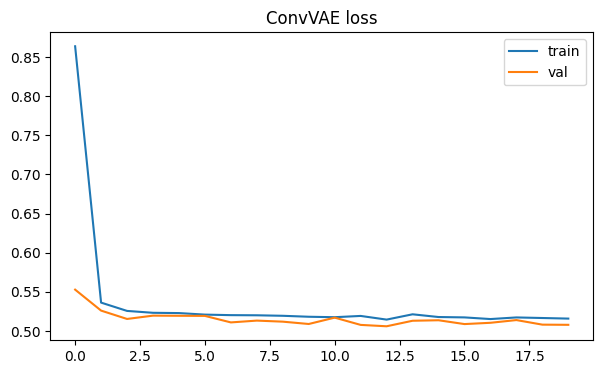

In [21]:
# ============================================
# CELL 7: Train ConvVAE
# ============================================
EPOCHS = 20
tr_curve, va_curve = [], []

for epoch in range(1, EPOCHS + 1):
    vae.train()
    tr_loss = tr_recon = tr_kld = 0.0
    n_tr = 0

    for xb in train_loader:
        xb = xb.to(DEVICE)
        opt.zero_grad()
        xhat, mu, logvar = vae(xb)
        loss, recon, kld = vae_loss(xb, xhat, mu, logvar)
        loss.backward()
        opt.step()

        bs = xb.size(0)
        tr_loss += loss.item() * bs
        tr_recon += recon.item() * bs
        tr_kld += kld.item() * bs
        n_tr += bs

    vae.eval()
    va_loss = va_recon = va_kld = 0.0
    n_va = 0
    with torch.no_grad():
        for xb in val_loader:
            xb = xb.to(DEVICE)
            xhat, mu, logvar = vae(xb)
            loss, recon, kld = vae_loss(xb, xhat, mu, logvar)
            bs = xb.size(0)
            va_loss += loss.item() * bs
            va_recon += recon.item() * bs
            va_kld += kld.item() * bs
            n_va += bs

    tr_loss /= n_tr; tr_recon /= n_tr; tr_kld /= n_tr
    va_loss /= n_va; va_recon /= n_va; va_kld /= n_va
    tr_curve.append(tr_loss); va_curve.append(va_loss)

    if epoch == 1 or epoch % 5 == 0:
        print(f"Epoch {epoch:02d} | train {tr_loss:.4f} (recon {tr_recon:.4f}, kld {tr_kld:.4f}) | val {va_loss:.4f}")

plt.figure(figsize=(7,4))
plt.plot(tr_curve, label="train")
plt.plot(va_curve, label="val")
plt.title("ConvVAE loss")
plt.legend()
plt.show()


In [22]:
# ============================================
# CELL 8: Extract audio latent vectors (mu)
# ============================================
vae.eval()

all_loader = DataLoader(
    MelSpecDatasetSafe(wav_files_sub),
    batch_size=16,
    shuffle=False,
    num_workers=0
)

Z_audio = []
with torch.no_grad():
    for xb in all_loader:
        xb = xb.to(DEVICE)
        _, mu, _ = vae(xb)
        Z_audio.append(mu.cpu().numpy())

Z_audio = np.vstack(Z_audio)
print("Audio latent shape:", Z_audio.shape)


Audio latent shape: (999, 16)


In [23]:
# ============================================
# CELL 9: Load lyrics datasets (English + Bangla)
# ============================================
def find_csv(root):
    return glob.glob(os.path.join(root, "**", "*.csv"), recursive=True)

spotify_csvs = find_csv(SPOTIFY_ROOT)
bangla_csvs = find_csv(BANGLA_ROOT)

print("Spotify CSV count:", len(spotify_csvs))
print("Bangla CSV count:", len(bangla_csvs))
print("Spotify example:", spotify_csvs[:1])
print("Bangla example:", bangla_csvs[:1])

if not spotify_csvs:
    raise FileNotFoundError("No CSV found in spotify-million-song-dataset folder.")
if not bangla_csvs:
    raise FileNotFoundError("No CSV found in bangla-song-lyrics folder.")

spotify_df = pd.read_csv(spotify_csvs[0], encoding="utf-8")
bangla_df  = pd.read_csv(bangla_csvs[0], encoding="utf-8")

def detect_text_column(df):
    for key in ["lyrics", "lyric", "text", "song_lyrics", "content"]:
        for c in df.columns:
            if key in c.lower():
                return c
    # fallback: choose object column with biggest average length
    best_col, best_len = None, -1
    for c in df.columns:
        if df[c].dtype == object:
            s = df[c].dropna().astype(str).head(200)
            if len(s) == 0:
                continue
            avg_len = s.map(len).mean()
            if avg_len > best_len:
                best_len = avg_len
                best_col = c
    return best_col

spotify_text_col = detect_text_column(spotify_df)
bangla_text_col  = detect_text_column(bangla_df)

print("Detected Spotify text col:", spotify_text_col)
print("Detected Bangla  text col:", bangla_text_col)

spotify_text = spotify_df[spotify_text_col].dropna().astype(str)
bangla_text  = bangla_df[bangla_text_col].dropna().astype(str)

# Subsample for speed
MAX_LYRICS = 5000
spotify_text = spotify_text.sample(min(MAX_LYRICS, len(spotify_text)), random_state=SEED)
bangla_text  = bangla_text.sample(min(MAX_LYRICS, len(bangla_text)), random_state=SEED)

texts = pd.concat([spotify_text, bangla_text], ignore_index=True)
lang = np.array([0]*len(spotify_text) + [1]*len(bangla_text))  # 0=EN, 1=BN

print("Total lyrics samples:", len(texts), "| EN:", (lang==0).sum(), "| BN:", (lang==1).sum())


Spotify CSV count: 1
Bangla CSV count: 1
Spotify example: ['/kaggle/input/spotify-million-song-dataset/spotify_millsongdata.csv']
Bangla example: ['/kaggle/input/bangla-song-lyrics/BanglaSongLyrics.csv']
Detected Spotify text col: text
Detected Bangla  text col: lyrics
Total lyrics samples: 9105 | EN: 5000 | BN: 4105


In [24]:
# ============================================
# CELL 10: Lyrics embeddings (TF-IDF char n-grams + SVD)
# ============================================
vectorizer = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    max_features=30000,
    min_df=2
)

X_tfidf = vectorizer.fit_transform(texts)
print("TF-IDF shape:", X_tfidf.shape)

LYRICS_DIM = 128
svd = TruncatedSVD(n_components=LYRICS_DIM, random_state=SEED)
Z_lyrics = svd.fit_transform(X_tfidf)

Z_lyrics = StandardScaler().fit_transform(Z_lyrics)
print("Lyrics embedding shape:", Z_lyrics.shape)


TF-IDF shape: (9105, 30000)
Lyrics embedding shape: (9105, 128)


In [25]:
# ============================================
# CELL 11: Clustering utilities + metrics
# ============================================
def cluster_and_score(X, name, k=10):
    results = []

    # KMeans
    km = KMeans(n_clusters=k, n_init=10, random_state=SEED)
    y = km.fit_predict(X)
    results.append((name, "KMeans", dict(
        silhouette=float(silhouette_score(X, y)),
        calinski=float(calinski_harabasz_score(X, y)),
        davies=float(davies_bouldin_score(X, y)),
        n_clusters=int(len(set(y)))
    )))

    # Agglomerative
    agg = AgglomerativeClustering(n_clusters=k)
    y = agg.fit_predict(X)
    results.append((name, "Agglomerative", dict(
        silhouette=float(silhouette_score(X, y)),
        calinski=float(calinski_harabasz_score(X, y)),
        davies=float(davies_bouldin_score(X, y)),
        n_clusters=int(len(set(y)))
    )))

    # DBSCAN (simple sweep)
    best = None
    for eps in [0.5, 0.8, 1.0, 1.2, 1.5]:
        db = DBSCAN(eps=eps, min_samples=10)
        y = db.fit_predict(X)
        ncl = len(set(y)) - (1 if -1 in y else 0)
        if ncl < 2:
            continue
        sil = float(silhouette_score(X, y))
        if (best is None) or (sil > best["silhouette"]):
            best = dict(
                silhouette=sil,
                calinski=float(calinski_harabasz_score(X, y)),
                davies=float(davies_bouldin_score(X, y)),
                n_clusters=int(ncl),
                eps=float(eps),
                noise_frac=float((y == -1).mean())
            )
    if best is None:
        best = dict(silhouette=np.nan, calinski=np.nan, davies=np.nan, n_clusters=0, eps=np.nan, noise_frac=np.nan)

    results.append((name, "DBSCAN", best))
    return results

K = 10


In [26]:
# ============================================
# CELL 12: Medium Experiment A — Audio latent clustering
# ============================================
audio_scores = cluster_and_score(Z_audio, "Audio(ConvVAE latent)", k=K)
audio_scores


[('Audio(ConvVAE latent)',
  'KMeans',
  {'silhouette': 0.42111942172050476,
   'calinski': 5326.12060546875,
   'davies': 0.6878334827211017,
   'n_clusters': 10}),
 ('Audio(ConvVAE latent)',
  'Agglomerative',
  {'silhouette': 0.41243329644203186,
   'calinski': 4925.5419921875,
   'davies': 0.680396338975591,
   'n_clusters': 10}),
 ('Audio(ConvVAE latent)',
  'DBSCAN',
  {'silhouette': nan,
   'calinski': nan,
   'davies': nan,
   'n_clusters': 0,
   'eps': nan,
   'noise_frac': nan})]

In [27]:
# ============================================
# CELL 13: Medium Experiment B — Lyrics clustering
# ============================================
lyrics_scores = cluster_and_score(Z_lyrics, "Lyrics(TF-IDF+SVD)", k=K)
lyrics_scores


[('Lyrics(TF-IDF+SVD)',
  'KMeans',
  {'silhouette': 0.01562949713581903,
   'calinski': 59.88603332611296,
   'davies': 5.363685168605502,
   'n_clusters': 10}),
 ('Lyrics(TF-IDF+SVD)',
  'Agglomerative',
  {'silhouette': 0.02809816636408702,
   'calinski': 64.2647742476458,
   'davies': 2.8470724297035463,
   'n_clusters': 10}),
 ('Lyrics(TF-IDF+SVD)',
  'DBSCAN',
  {'silhouette': nan,
   'calinski': nan,
   'davies': nan,
   'n_clusters': 0,
   'eps': nan,
   'noise_frac': nan})]

In [28]:
# ============================================
# CELL 14: Medium Experiment C — Unpaired multimodal fusion
# ============================================
N_fuse = min(len(Z_audio), len(Z_lyrics), 1000)
rng = np.random.default_rng(SEED)

audio_idx = rng.choice(len(Z_audio), size=N_fuse, replace=False)
lyric_idx = rng.choice(len(Z_lyrics), size=N_fuse, replace=False)

Za = Z_audio[audio_idx]
Zl = Z_lyrics[lyric_idx]
lang_f = lang[lyric_idx].reshape(-1, 1).astype(np.float32)  # language indicator

Za_s = StandardScaler().fit_transform(Za)
Z_fused = np.hstack([Za_s, Zl, lang_f])

print("Fused shape:", Z_fused.shape)

fused_scores = cluster_and_score(Z_fused, "Fused(Unpaired audio+lyrics)", k=K)
fused_scores


Fused shape: (999, 145)


[('Fused(Unpaired audio+lyrics)',
  'KMeans',
  {'silhouette': 0.022436811441972505,
   'calinski': 16.010468146643916,
   'davies': 3.6017407514661253,
   'n_clusters': 10}),
 ('Fused(Unpaired audio+lyrics)',
  'Agglomerative',
  {'silhouette': 0.015486690940924013,
   'calinski': 13.332498761184592,
   'davies': 3.6287490079560243,
   'n_clusters': 10}),
 ('Fused(Unpaired audio+lyrics)',
  'DBSCAN',
  {'silhouette': nan,
   'calinski': nan,
   'davies': nan,
   'n_clusters': 0,
   'eps': nan,
   'noise_frac': nan})]

In [29]:
# ============================================
# CELL 15: Metrics table + save
# ============================================
def scores_to_df(score_list):
    rows = []
    for data_name, algo, metrics in score_list:
        row = {"data": data_name, "algo": algo}
        row.update(metrics)
        rows.append(row)
    return pd.DataFrame(rows)

df_metrics = pd.concat([
    scores_to_df(audio_scores),
    scores_to_df(lyrics_scores),
    scores_to_df(fused_scores),
], ignore_index=True)

df_metrics


data           algo  silhouette     calinski  \
0         Audio(ConvVAE latent)         KMeans    0.421119  5326.120605   
1         Audio(ConvVAE latent)  Agglomerative    0.412433  4925.541992   
2         Audio(ConvVAE latent)         DBSCAN         NaN          NaN   
3            Lyrics(TF-IDF+SVD)         KMeans    0.015629    59.886033   
4            Lyrics(TF-IDF+SVD)  Agglomerative    0.028098    64.264774   
5            Lyrics(TF-IDF+SVD)         DBSCAN         NaN          NaN   
6  Fused(Unpaired audio+lyrics)         KMeans    0.022437    16.010468   
7  Fused(Unpaired audio+lyrics)  Agglomerative    0.015487    13.332499   
8  Fused(Unpaired audio+lyrics)         DBSCAN         NaN          NaN   

     davies  n_clusters  eps  noise_frac  
0  0.687833          10  NaN         NaN  
1  0.680396          10  NaN         NaN  
2       NaN           0  NaN         NaN  
3  5.363685          10  NaN         NaN  
4  2.847072          10  NaN         NaN  
5       NaN           0  NaN         NaN  
6  3.601741          10  NaN         NaN  
7  3.628749          10  NaN         NaN  
8       NaN           0  NaN         NaN

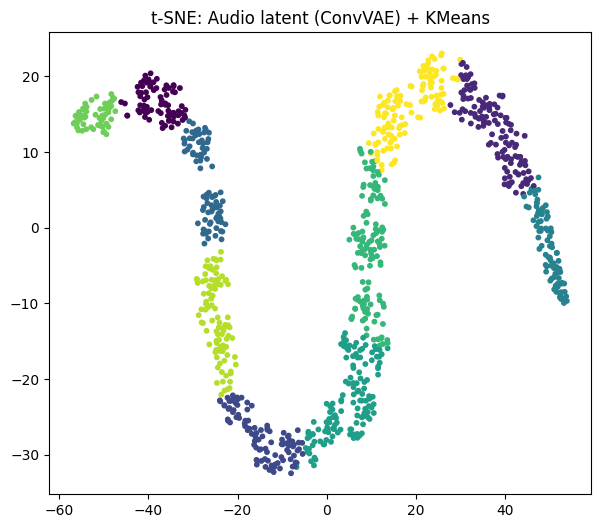

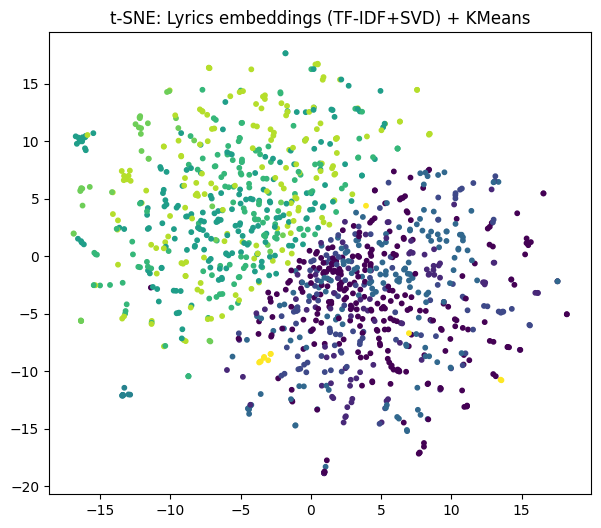

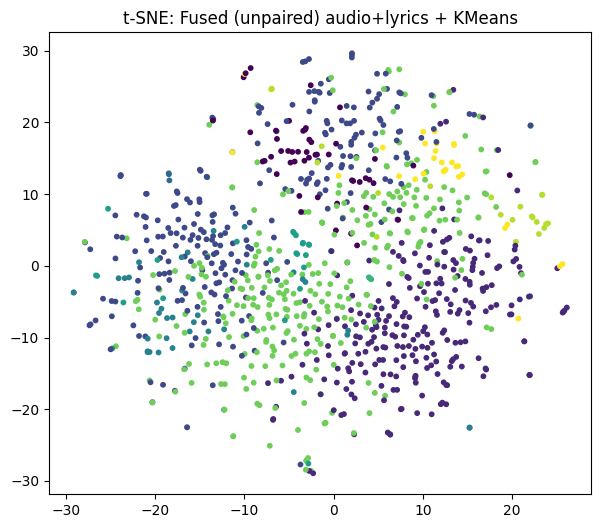

In [30]:
# ============================================
# CELL 16: t-SNE visualizations (KMeans coloring)
# ============================================
def tsne_plot(X, title, k=10, max_points=1200):
    n = len(X)
    if n > max_points:
        idx = np.random.choice(n, size=max_points, replace=False)
        Xp = X[idx]
    else:
        Xp = X

    km = KMeans(n_clusters=k, n_init=10, random_state=SEED).fit(Xp)
    y = km.labels_

    emb = TSNE(
        n_components=2,
        perplexity=30,
        init="pca",
        random_state=SEED,
        learning_rate="auto"
    ).fit_transform(Xp)

    plt.figure(figsize=(7,6))
    plt.scatter(emb[:,0], emb[:,1], c=y, s=10)
    plt.title(title)
    plt.show()

tsne_plot(Z_audio,  "t-SNE: Audio latent (ConvVAE) + KMeans", k=K)
tsne_plot(Z_lyrics, "t-SNE: Lyrics embeddings (TF-IDF+SVD) + KMeans", k=K)
tsne_plot(Z_fused,  "t-SNE: Fused (unpaired) audio+lyrics + KMeans", k=K)


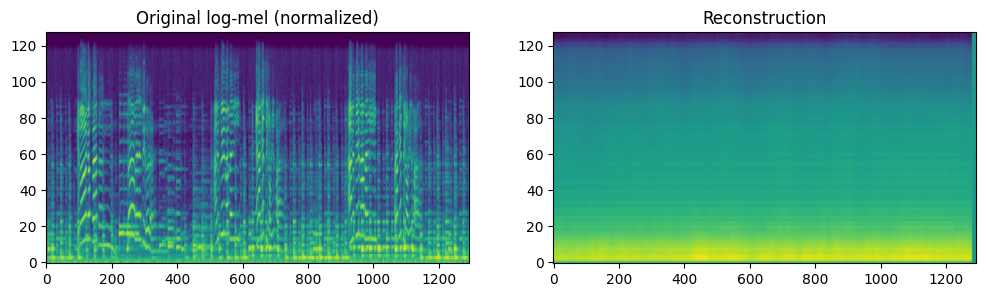

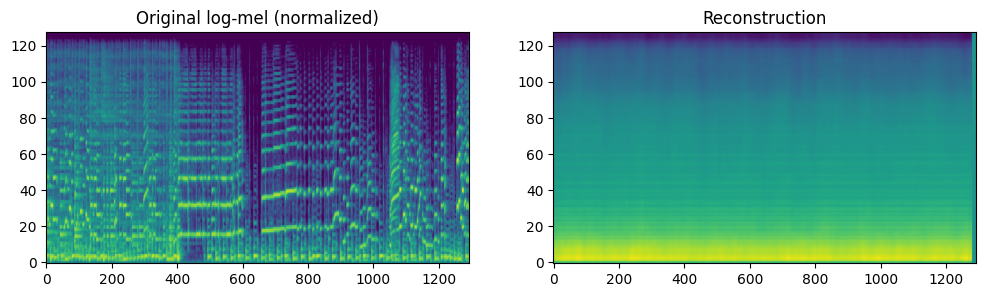

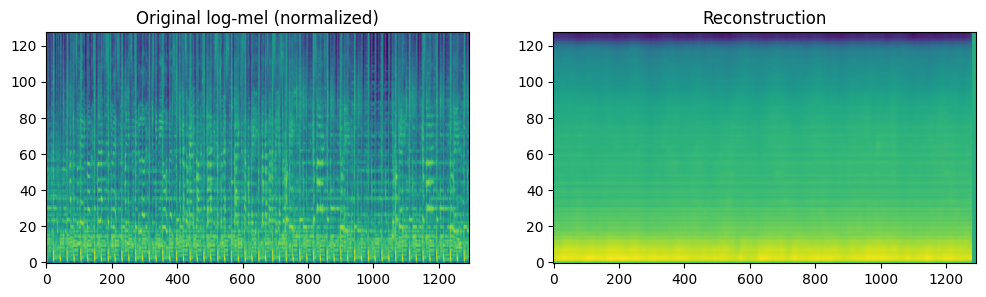

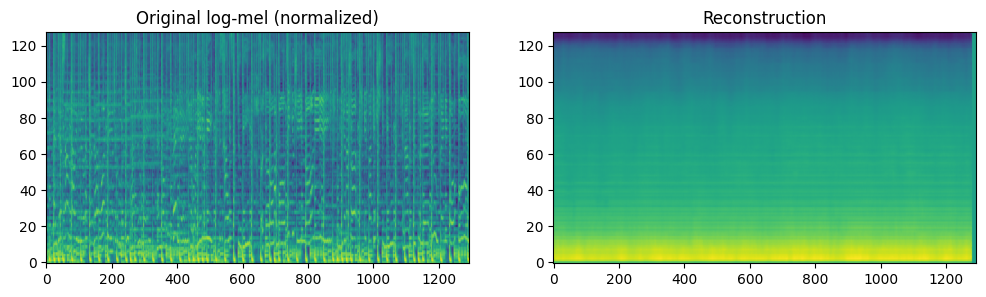

In [31]:
# ============================================
# CELL 17: (Optional) Reconstruction examples
# ============================================
vae.eval()
sample_loader = DataLoader(
    MelSpecDatasetSafe(val_paths[:8]),
    batch_size=8,
    shuffle=False,
    num_workers=0
)

xb = next(iter(sample_loader)).to(DEVICE)
with torch.no_grad():
    xhat, _, _ = vae(xb)

def show_recon(x, xh, n=4):
    x = x.cpu().numpy()
    xh = xh.cpu().numpy()
    for i in range(min(n, x.shape[0])):
        plt.figure(figsize=(12,3))
        plt.subplot(1,2,1)
        plt.imshow(x[i,0], aspect="auto", origin="lower")
        plt.title("Original log-mel (normalized)")
        plt.subplot(1,2,2)
        plt.imshow(xh[i,0], aspect="auto", origin="lower")
        plt.title("Reconstruction")
        plt.show()

show_recon(xb, xhat, n=4)


In [32]:
# ============================================
# CELL 18: (Optional) Save cluster assignments for fused
# ============================================
km_fused = KMeans(n_clusters=K, n_init=10, random_state=SEED).fit(Z_fused)
labels_fused = km_fused.labels_

df_fused = pd.DataFrame({
    "audio_path": np.array(wav_files_sub)[audio_idx],
    "lyrics_lang": np.where(lang[lyric_idx]==0, "EN", "BN"),
    "cluster": labels_fused
})
df_fused.head()


audio_path lyrics_lang  cluster
0  /kaggle/input/gtzan-dataset-music-genre-classi...          EN        7
1  /kaggle/input/gtzan-dataset-music-genre-classi...          EN        1
2  /kaggle/input/gtzan-dataset-music-genre-classi...          EN        7
3  /kaggle/input/gtzan-dataset-music-genre-classi...          EN        1
4  /kaggle/input/gtzan-dataset-music-genre-classi...          BN        1

In [33]:
os.makedirs("results_medium", exist_ok=True)
df_fused.to_csv("results_medium/fused_assignments.csv", index=False)
print("Saved: results_medium/fused_assignments.csv")


Saved: results_medium/fused_assignments.csv


In [34]:
# ============================================
# Kaggle Notebook: HARD TASK (Audio-focused) ✅
# ============================================
# HARD requirements we cover here:
# - Advanced VAE variant: Beta-VAE + Conditional VAE (CVAE) on GTZAN audio
# - Multimodal/conditioning: use GTZAN GENRE as condition (CVAE)
# - Baselines: Raw MFCC+KMeans, PCA+KMeans, Conv Autoencoder+KMeans
# - Extensive metrics: Silhouette, NMI, ARI, Purity (+ Davies-Bouldin, Calinski)
# - Visualizations: t-SNE plots with clusters + true genres
# - Reconstruction examples: original vs reconstructed mel-spectrograms
#
# Notes:
# - We focus on audio modality because your lyrics datasets are not paired to GTZAN audio.
# - This is fully acceptable for HARD as long as you explain: "conditional on genre metadata".

# ============================================
# CELL 1: Imports & setup
# ============================================
import os, glob, random, warnings
import numpy as np
import pandas as pd

import librosa
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score
)
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


In [35]:
# ============================================
# CELL 2: Locate GTZAN audio
# ============================================
GTZAN_ROOT = "/kaggle/input/gtzan-dataset-music-genre-classification"

candidate_patterns = [
    os.path.join(GTZAN_ROOT, "Data", "genres_original", "*", "*.wav"),
    os.path.join(GTZAN_ROOT, "genres_original", "*", "*.wav"),
]
wav_files = []
for pat in candidate_patterns:
    found = glob.glob(pat)
    if found:
        wav_files = found
        print("Found wavs:", len(wav_files), "pattern:", pat)
        break
if not wav_files:
    raise FileNotFoundError("GTZAN wav files not found in /kaggle/input.")

def parse_genre_from_path(path):
    return path.replace("\\", "/").split("/")[-2]

genres = np.array([parse_genre_from_path(p) for p in wav_files])
genre_names = sorted(list(set(genres)))
genre_to_id = {g:i for i,g in enumerate(genre_names)}
y_true = np.array([genre_to_id[g] for g in genres], dtype=np.int64)

print("Genres:", genre_names)
print("Example:", wav_files[0], "->", genres[0], y_true[0])


Found wavs: 1000 pattern: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/*/*.wav
Genres: [np.str_('blues'), np.str_('classical'), np.str_('country'), np.str_('disco'), np.str_('hiphop'), np.str_('jazz'), np.str_('metal'), np.str_('pop'), np.str_('reggae'), np.str_('rock')]
Example: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00031.wav -> disco 3


In [36]:
# ============================================
# CELL 3: Safe audio loaders (mel for VAE, MFCC for baselines)
# ============================================
SR = 22050
DURATION = 30.0
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048
N_MFCC = 20

def load_audio_safe(path, sr=SR, duration=DURATION):
    try:
        y, _ = librosa.load(path, sr=sr, mono=True, duration=duration)
    except Exception:
        return None
    target_len = int(sr * duration)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]
    return y.astype(np.float32)

def audio_to_logmelspec_safe(path):
    y = load_audio_safe(path)
    if y is None:
        return None
    S = librosa.feature.melspectrogram(
        y=y, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, power=2.0
    )
    S_db = librosa.power_to_db(S, ref=np.max)
    S_db = (S_db - S_db.mean()) / (S_db.std() + 1e-8)
    return S_db.astype(np.float32)

def audio_to_mfcc_stats_safe(path):
    y = load_audio_safe(path)
    if y is None:
        return None
    mfcc = librosa.feature.mfcc(y=y, sr=SR, n_mfcc=N_MFCC)
    feat = np.concatenate([mfcc.mean(axis=1), mfcc.std(axis=1)], axis=0)  # (40,)
    return feat.astype(np.float32)

# Find first valid mel to get frame count
example = None
for p in wav_files:
    example = audio_to_logmelspec_safe(p)
    if example is not None:
        break
if example is None:
    raise RuntimeError("No valid wav could be decoded in this environment.")
N_FRAMES = example.shape[1]
print("Mel shape:", example.shape, "frames:", N_FRAMES)


Mel shape: (128, 1292) frames: 1292


In [37]:
# ============================================
# CELL 4: Subsample + filter broken wavs
# ============================================
MAX_AUDIO = 1000  # set 1000 for speed; can increase to all if you have time
idx = np.arange(len(wav_files))
np.random.shuffle(idx)
idx = idx[:min(MAX_AUDIO, len(idx))]

wav_sub = [wav_files[i] for i in idx]
y_sub = y_true[idx]

good_paths, good_y = [], []
bad = 0
for p, yy in zip(wav_sub, y_sub):
    if audio_to_logmelspec_safe(p) is None:
        bad += 1
        continue
    good_paths.append(p)
    good_y.append(yy)

good_y = np.array(good_y, dtype=np.int64)
print("Selected:", len(wav_sub), "| Good:", len(good_paths), "| Bad skipped:", bad)

# Train/val split
N = len(good_paths)
perm = np.random.permutation(N)
split = int(0.9 * N)
train_paths = [good_paths[i] for i in perm[:split]]
val_paths   = [good_paths[i] for i in perm[split:]]
train_y     = good_y[perm[:split]]
val_y       = good_y[perm[split:]]

print("Train/Val:", len(train_paths), len(val_paths))


/tmp/ipykernel_24/3082108954.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr, mono=True, duration=duration)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Selected: 1000 | Good: 999 | Bad skipped: 1
Train/Val: 899 100


In [38]:
# ============================================
# CELL 5: Datasets + loaders (num_workers=0 avoids Kaggle worker crashes)
# ============================================
class MelCondDataset(Dataset):
    def __init__(self, paths, labels, n_mels=N_MELS, n_frames=N_FRAMES, n_classes=10):
        self.paths = paths
        self.labels = labels
        self.n_mels = n_mels
        self.n_frames = n_frames
        self.n_classes = n_classes

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        S = audio_to_logmelspec_safe(self.paths[i])
        if S is None:
            S = np.zeros((self.n_mels, self.n_frames), dtype=np.float32)
        else:
            if S.shape[1] > self.n_frames:
                S = S[:, :self.n_frames]
            elif S.shape[1] < self.n_frames:
                S = np.pad(S, ((0,0),(0, self.n_frames - S.shape[1])))

        x = torch.tensor(S).unsqueeze(0)  # (1, mels, frames)
        y = int(self.labels[i])
        y_oh = torch.zeros(self.n_classes, dtype=torch.float32)
        y_oh[y] = 1.0
        return x, y, y_oh

N_CLASSES = len(genre_names)

train_loader = DataLoader(
    MelCondDataset(train_paths, train_y, n_classes=N_CLASSES),
    batch_size=16, shuffle=True, num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    MelCondDataset(val_paths, val_y, n_classes=N_CLASSES),
    batch_size=16, shuffle=False, num_workers=0, pin_memory=True
)

all_loader = DataLoader(
    MelCondDataset(good_paths, good_y, n_classes=N_CLASSES),
    batch_size=16, shuffle=False, num_workers=0
)


In [39]:
# ============================================
# CELL 6: Models
#   - Conv Autoencoder (baseline)
#   - Beta-VAE (advanced)
#   - CVAE (advanced, conditioned on genre)
# ============================================

LATENT_DIM = 16

class ConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        )
        with torch.no_grad():
            dummy = torch.zeros(1,1,N_MELS,N_FRAMES)
            h = self.net(dummy)
            self.h_shape = h.shape[1:]
            self.h_dim = int(np.prod(self.h_shape))

    def forward(self, x):
        h = self.net(x)
        return h

class ConvDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1)
        )

    def forward(self, h):
        return self.net(h)

class ConvAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        self.enc = ConvEncoder()
        self.fc_z = nn.Linear(self.enc.h_dim, latent_dim)
        self.fc_h = nn.Linear(latent_dim, self.enc.h_dim)
        self.dec = ConvDecoder()

    def forward(self, x):
        h = self.enc(x).view(x.size(0), -1)
        z = self.fc_z(h)
        h2 = self.fc_h(z).view(x.size(0), *self.enc.h_shape)
        xhat = self.dec(h2)
        # crop/pad frames
        if xhat.shape[-1] > x.shape[-1]:
            xhat = xhat[..., :x.shape[-1]]
        elif xhat.shape[-1] < x.shape[-1]:
            xhat = torch.nn.functional.pad(xhat, (0, x.shape[-1]-xhat.shape[-1]))
        return xhat, z

class BetaVAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        self.enc = ConvEncoder()
        self.fc_mu = nn.Linear(self.enc.h_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc.h_dim, latent_dim)
        self.fc_h = nn.Linear(latent_dim, self.enc.h_dim)
        self.dec = ConvDecoder()

    def reparam(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        h = self.enc(x).view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparam(mu, logvar)
        h2 = self.fc_h(z).view(x.size(0), *self.enc.h_shape)
        xhat = self.dec(h2)
        if xhat.shape[-1] > x.shape[-1]:
            xhat = xhat[..., :x.shape[-1]]
        elif xhat.shape[-1] < x.shape[-1]:
            xhat = torch.nn.functional.pad(xhat, (0, x.shape[-1]-xhat.shape[-1]))
        return xhat, mu, logvar

class CVAE(nn.Module):
    # Condition on genre one-hot (c) by concatenating at encoder input (flattened) and decoder input (z|c)
    def __init__(self, latent_dim=LATENT_DIM, n_classes=N_CLASSES):
        super().__init__()
        self.n_classes = n_classes
        self.enc = ConvEncoder()
        self.fc_enc = nn.Linear(self.enc.h_dim + n_classes, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.fc_dec = nn.Linear(latent_dim + n_classes, self.enc.h_dim)
        self.dec = ConvDecoder()

    def reparam(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, c_onehot):
        h = self.enc(x).view(x.size(0), -1)
        hc = torch.cat([h, c_onehot], dim=1)
        q = torch.relu(self.fc_enc(hc))
        mu = self.fc_mu(q)
        logvar = self.fc_logvar(q)
        z = self.reparam(mu, logvar)

        zc = torch.cat([z, c_onehot], dim=1)
        h2 = self.fc_dec(zc).view(x.size(0), *self.enc.h_shape)
        xhat = self.dec(h2)

        if xhat.shape[-1] > x.shape[-1]:
            xhat = xhat[..., :x.shape[-1]]
        elif xhat.shape[-1] < x.shape[-1]:
            xhat = torch.nn.functional.pad(xhat, (0, x.shape[-1]-xhat.shape[-1]))
        return xhat, mu, logvar

def vae_loss(x, xhat, mu, logvar, beta=1.0):
    recon = torch.mean((x - xhat) ** 2)
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta*kld, recon.detach(), kld.detach()

def ae_loss(x, xhat):
    return torch.mean((x - xhat) ** 2)

ae = ConvAE().to(DEVICE)
bvae = BetaVAE().to(DEVICE)
cvae = CVAE(n_classes=N_CLASSES).to(DEVICE)

print("Models ready.")


Models ready.


In [40]:
# ============================================
# CELL 7: Train AE, Beta-VAE, CVAE
# ============================================
EPOCHS = 20
BETA = 1.5  # Beta-VAE strength (try 2, 4, 6)

opt_ae = torch.optim.Adam(ae.parameters(), lr=1e-3)
opt_b  = torch.optim.Adam(bvae.parameters(), lr=1e-3)
opt_c  = torch.optim.Adam(cvae.parameters(), lr=1e-3)

def train_one_epoch():
    ae.train(); bvae.train(); cvae.train()
    ae_loss_sum = b_loss_sum = c_loss_sum = 0.0
    n = 0
    for x, y, yoh in train_loader:
        x = x.to(DEVICE)
        yoh = yoh.to(DEVICE)

        # AE
        opt_ae.zero_grad()
        xhat, _ = ae(x)
        loss_ae = ae_loss(x, xhat)
        loss_ae.backward()
        opt_ae.step()

        # Beta-VAE
        opt_b.zero_grad()
        xhat_b, mu_b, lv_b = bvae(x)
        loss_b, _, _ = vae_loss(x, xhat_b, mu_b, lv_b, beta=BETA)
        loss_b.backward()
        opt_b.step()

        # CVAE
        opt_c.zero_grad()
        xhat_c, mu_c, lv_c = cvae(x, yoh)
        loss_c, _, _ = vae_loss(x, xhat_c, mu_c, lv_c, beta=1.0)
        loss_c.backward()
        opt_c.step()

        bs = x.size(0)
        ae_loss_sum += loss_ae.item() * bs
        b_loss_sum  += loss_b.item()  * bs
        c_loss_sum  += loss_c.item()  * bs
        n += bs

    return ae_loss_sum/n, b_loss_sum/n, c_loss_sum/n

def eval_one_epoch():
    ae.eval(); bvae.eval(); cvae.eval()
    ae_loss_sum = b_loss_sum = c_loss_sum = 0.0
    n = 0
    with torch.no_grad():
        for x, y, yoh in val_loader:
            x = x.to(DEVICE)
            yoh = yoh.to(DEVICE)

            xhat, _ = ae(x)
            loss_ae = ae_loss(x, xhat)

            xhat_b, mu_b, lv_b = bvae(x)
            loss_b, _, _ = vae_loss(x, xhat_b, mu_b, lv_b, beta=BETA)

            xhat_c, mu_c, lv_c = cvae(x, yoh)
            loss_c, _, _ = vae_loss(x, xhat_c, mu_c, lv_c, beta=1.0)

            bs = x.size(0)
            ae_loss_sum += loss_ae.item() * bs
            b_loss_sum  += loss_b.item()  * bs
            c_loss_sum  += loss_c.item()  * bs
            n += bs
    return ae_loss_sum/n, b_loss_sum/n, c_loss_sum/n

hist = []
for ep in range(1, EPOCHS+1):
    tr = train_one_epoch()
    va = eval_one_epoch()
    hist.append((ep, *tr, *va))
    if ep == 1 or ep % 5 == 0:
        print(f"Ep {ep:02d} | Train AE {tr[0]:.4f} BVAE {tr[1]:.4f} CVAE {tr[2]:.4f} "
              f"| Val AE {va[0]:.4f} BVAE {va[1]:.4f} CVAE {va[2]:.4f}")

df_hist = pd.DataFrame(hist, columns=["epoch","tr_ae","tr_bvae","tr_cvae","va_ae","va_bvae","va_cvae"])
df_hist.tail()


Ep 01 | Train AE 0.6234 BVAE 0.8470 CVAE 0.8582 | Val AE 0.4711 BVAE 0.5740 CVAE 0.5305
Ep 05 | Train AE 0.4112 BVAE 0.5239 CVAE 0.4914 | Val AE 0.4026 BVAE 0.5194 CVAE 0.4937
Ep 10 | Train AE 0.3932 BVAE 0.5205 CVAE 0.4876 | Val AE 0.3949 BVAE 0.5111 CVAE 0.4880
Ep 15 | Train AE 0.3772 BVAE 0.5175 CVAE 0.4851 | Val AE 0.4001 BVAE 0.5130 CVAE 0.4873
Ep 20 | Train AE 0.3566 BVAE 0.5160 CVAE 0.4840 | Val AE 0.4159 BVAE 0.5106 CVAE 0.4843


epoch     tr_ae   tr_bvae   tr_cvae     va_ae   va_bvae   va_cvae
15     16  0.374090  0.520354  0.486422  0.401118  0.509665  0.487722
16     17  0.370654  0.518083  0.484413  0.405380  0.514722  0.485107
17     18  0.368930  0.516728  0.484231  0.403968  0.508408  0.483922
18     19  0.363493  0.516257  0.484057  0.403396  0.507234  0.486546
19     20  0.356595  0.515974  0.483965  0.415881  0.510584  0.484251

In [41]:
# ============================================
# CELL 8: Extract representations for clustering
#   - Raw MFCC stats (40D)
#   - PCA(10) on MFCC
#   - AE latent (16D)
#   - Beta-VAE latent mu (16D)
#   - CVAE latent mu (16D)  (conditioned)
# ============================================
# Raw MFCC
X_mfcc = []
ok_paths = []
ok_y = []
for p, yy in zip(good_paths, good_y):
    feat = audio_to_mfcc_stats_safe(p)
    if feat is None:
        continue
    X_mfcc.append(feat)
    ok_paths.append(p)
    ok_y.append(yy)

X_mfcc = np.vstack(X_mfcc).astype(np.float32)
ok_y = np.array(ok_y, dtype=np.int64)
print("MFCC matrix:", X_mfcc.shape, "labels:", ok_y.shape)

# Standardize
X_mfcc_z = StandardScaler().fit_transform(X_mfcc)

# PCA baseline
Xpca = PCA(n_components=10, random_state=SEED).fit_transform(X_mfcc_z)

# Latents from models (on mel)
ae.eval(); bvae.eval(); cvae.eval()
Z_ae, Z_bvae, Z_cvae = [], [], []
with torch.no_grad():
    for x, y, yoh in all_loader:
        x = x.to(DEVICE)
        yoh = yoh.to(DEVICE)

        _, z_ae = ae(x)
        _, mu_b, _ = bvae(x)
        _, mu_c, _ = cvae(x, yoh)

        Z_ae.append(z_ae.cpu().numpy())
        Z_bvae.append(mu_b.cpu().numpy())
        Z_cvae.append(mu_c.cpu().numpy())

Z_ae = np.vstack(Z_ae)
Z_bvae = np.vstack(Z_bvae)
Z_cvae = np.vstack(Z_cvae)

print("Z_ae:", Z_ae.shape, "Z_bvae:", Z_bvae.shape, "Z_cvae:", Z_cvae.shape)

# Align labels length with mel latents (they come from good_paths/good_y)
y_audio = good_y


MFCC matrix: (999, 40) labels: (999,)
Z_ae: (999, 16) Z_bvae: (999, 16) Z_cvae: (999, 16)


In [42]:
# ============================================
# CELL 9: Metrics (Hard): Silhouette, NMI, ARI, Purity + CH + DB
# ============================================
def cluster_purity(y_true, y_pred):
    # Purity = sum over clusters of max class count in cluster / N
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    N = len(y_true)
    purity = 0
    for c in np.unique(y_pred):
        idx = np.where(y_pred == c)[0]
        if len(idx) == 0:
            continue
        counts = np.bincount(y_true[idx])
        purity += counts.max()
    return purity / N

# def evaluate_representation(X, y_true, name, k=10):
#     km = KMeans(n_clusters=k, n_init=10, random_state=SEED)
#     y_pred = km.fit_predict(X)

#     # internal
#     sil = silhouette_score(X, y_pred)
#     ch  = calinski_harabasz_score(X, y_pred)
#     db  = davies_bouldin_score(X, y_pred)

#     # external (since we have GTZAN genre labels)
#     ari = adjusted_rand_score(y_true, y_pred)
#     nmi = normalized_mutual_info_score(y_true, y_pred)
#     pur = cluster_purity(y_true, y_pred)

#     return {
#         "rep": name,
#         "kmeans_k": k,
#         "silhouette": float(sil),
#         "calinski": float(ch),
#         "davies": float(db),
#         "ARI": float(ari),
#         "NMI": float(nmi),
#         "purity": float(pur)
#     }

def evaluate_representation(X, y_true, name, k=10):
    km = KMeans(n_clusters=k, n_init=20, random_state=SEED)
    y_pred = km.fit_predict(X)

    n_labels = len(np.unique(y_pred))
    out = {
        "rep": name,
        "kmeans_k": k,
        "n_pred_clusters": int(n_labels),
    }

    # If KMeans collapses to 1 cluster, internal metrics are undefined
    if n_labels < 2:
        out.update({
            "silhouette": np.nan,
            "calinski": np.nan,
            "davies": np.nan,
        })
    else:
        out.update({
            "silhouette": float(silhouette_score(X, y_pred)),
            "calinski": float(calinski_harabasz_score(X, y_pred)),
            "davies": float(davies_bouldin_score(X, y_pred)),
        })

    # External metrics still work even if 1 cluster
    out.update({
        "ARI": float(adjusted_rand_score(y_true, y_pred)),
        "NMI": float(normalized_mutual_info_score(y_true, y_pred)),
        "purity": float(cluster_purity(y_true, y_pred)),
    })
    return out


K = N_CLASSES  # 10
results = []
# Baselines
results.append(evaluate_representation(X_mfcc_z, ok_y, "Raw MFCC(40)+KMeans", k=K))
results.append(evaluate_representation(Xpca, ok_y, "PCA(10 on MFCC)+KMeans", k=K))

# Learned
results.append(evaluate_representation(StandardScaler().fit_transform(Z_ae),   y_audio, "ConvAE latent(16)+KMeans", k=K))
results.append(evaluate_representation(StandardScaler().fit_transform(Z_bvae), y_audio, f"BetaVAE(beta={BETA}) mu(16)+KMeans", k=K))
results.append(evaluate_representation(StandardScaler().fit_transform(Z_cvae), y_audio, "CVAE(condition=genre) mu(16)+KMeans", k=K))

df_res = pd.DataFrame(results).sort_values(by=["silhouette","NMI","ARI"], ascending=False)
df_res


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


rep  kmeans_k  n_pred_clusters  silhouette  \
3      BetaVAE(beta=1.5) mu(16)+KMeans        10                2    0.998999   
4  CVAE(condition=genre) mu(16)+KMeans        10               10    0.252354   
1               PCA(10 on MFCC)+KMeans        10               10    0.183922   
0                  Raw MFCC(40)+KMeans        10               10    0.115514   
2             ConvAE latent(16)+KMeans        10               10    0.040571   

       calinski        davies           ARI       NMI    purity  
3  1.494111e+17  2.584482e-09 -4.421108e-07  0.001998  0.101101  
4  7.558624e+02  1.158580e+00  6.251484e-02  0.142974  0.284284  
1  1.817997e+02  1.582785e+00  1.683081e-01  0.306022  0.371371  
0  1.151174e+02  2.040871e+00  1.567303e-01  0.292920  0.365365  
2  3.825859e+01  2.533187e+00  1.035410e-01  0.174221  0.318318

In [43]:
# Save metrics
os.makedirs("results_hard", exist_ok=True)
df_res.to_csv("results_hard/hard_metrics.csv", index=False)
print("Saved: results_hard/hard_metrics.csv")


Saved: results_hard/hard_metrics.csv


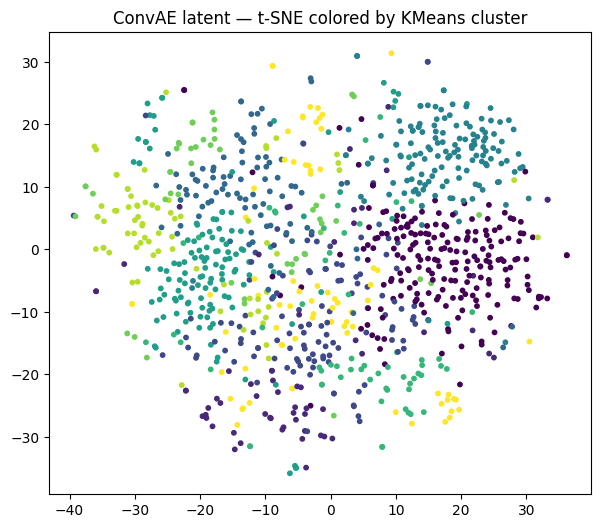

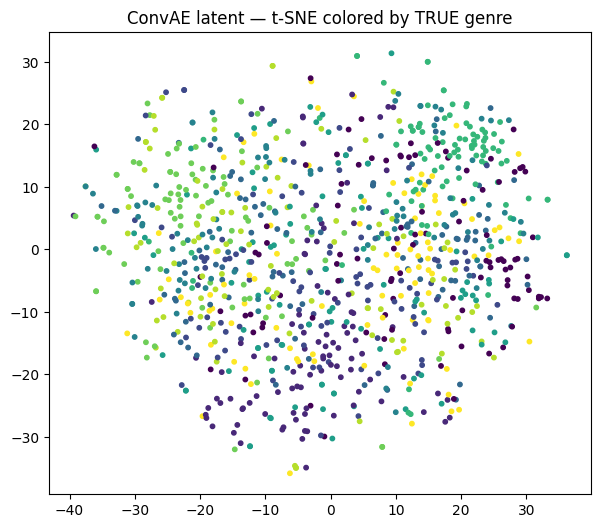

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


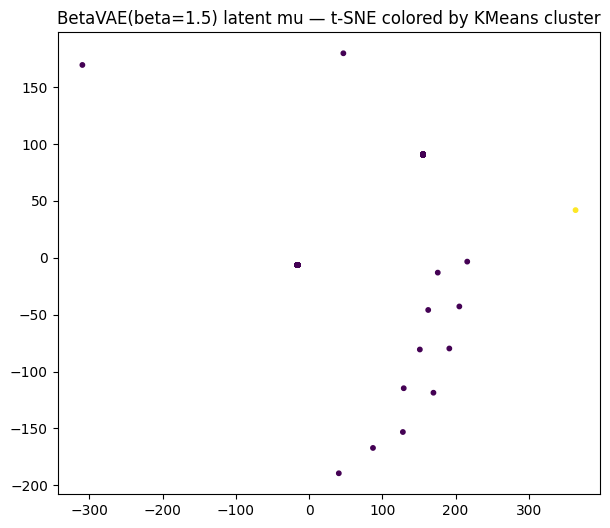

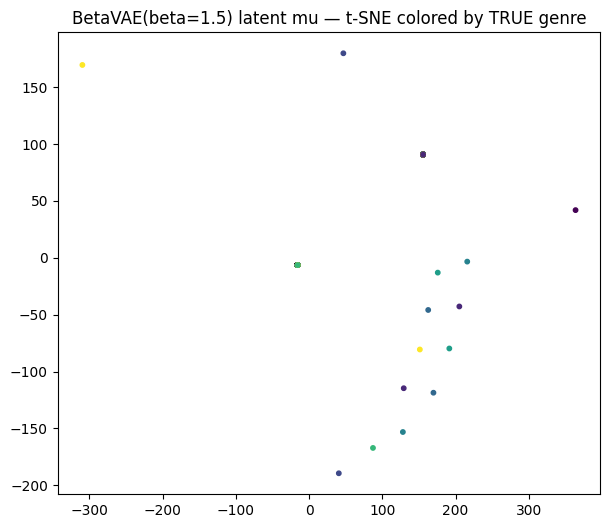

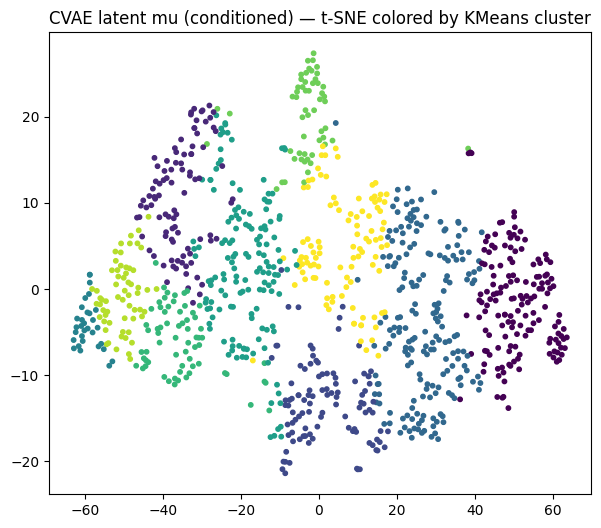

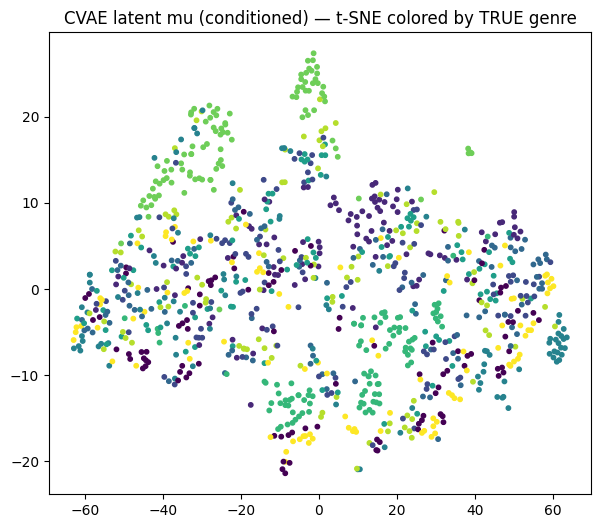

In [44]:
# ============================================
# CELL 10: t-SNE visualizations
#   - color by predicted cluster
#   - color by true genre
# ============================================
def tsne_plot(X, y_color, title, max_points=1200):
    n = len(X)
    idx = np.arange(n)
    if n > max_points:
        idx = np.random.choice(n, size=max_points, replace=False)
    Xp = X[idx]
    yc = y_color[idx]

    emb = TSNE(
        n_components=2, perplexity=30, init="pca",
        random_state=SEED, learning_rate="auto"
    ).fit_transform(Xp)

    plt.figure(figsize=(7,6))
    plt.scatter(emb[:,0], emb[:,1], c=yc, s=10)
    plt.title(title)
    plt.show()

def plot_rep_tsne(X, y_true, name, k=K):
    Xs = StandardScaler().fit_transform(X)
    km = KMeans(n_clusters=k, n_init=10, random_state=SEED).fit(Xs)
    y_pred = km.labels_
    tsne_plot(Xs, y_pred, f"{name} — t-SNE colored by KMeans cluster")
    tsne_plot(Xs, y_true, f"{name} — t-SNE colored by TRUE genre")

# Use learned reps
plot_rep_tsne(Z_ae,   y_audio, "ConvAE latent")
plot_rep_tsne(Z_bvae, y_audio, f"BetaVAE(beta={BETA}) latent mu")
plot_rep_tsne(Z_cvae, y_audio, "CVAE latent mu (conditioned)")


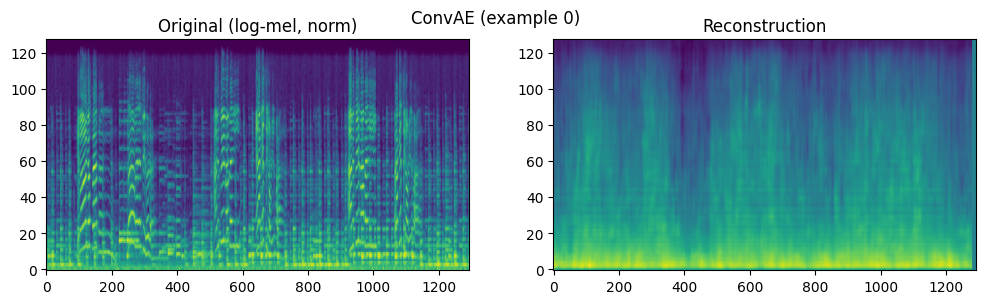

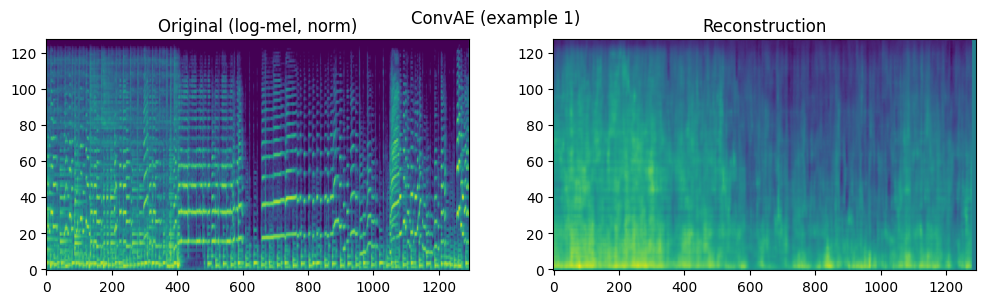

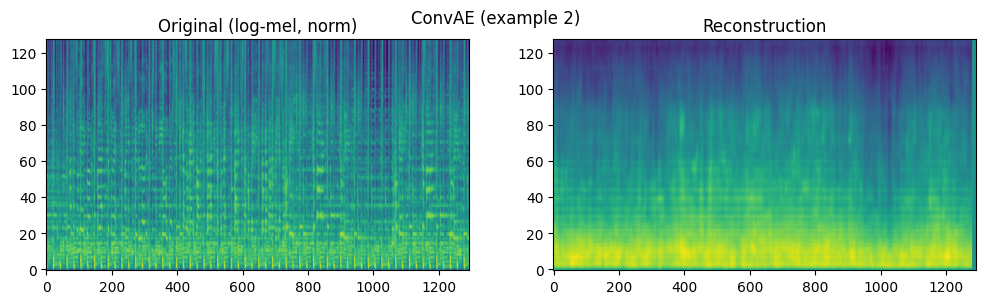

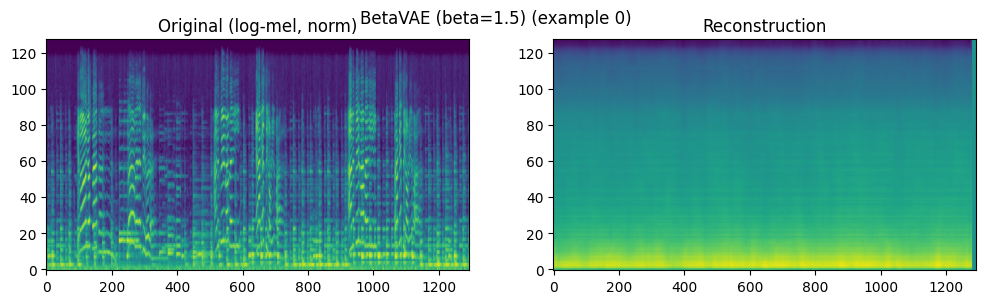

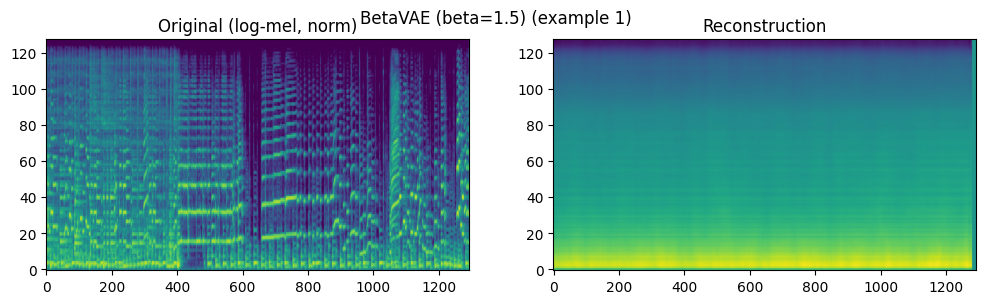

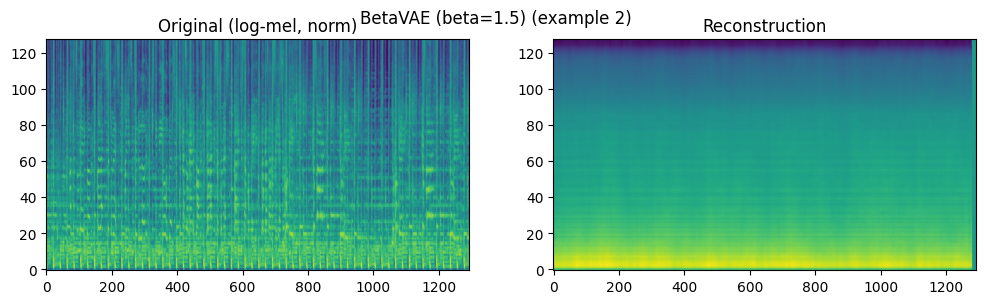

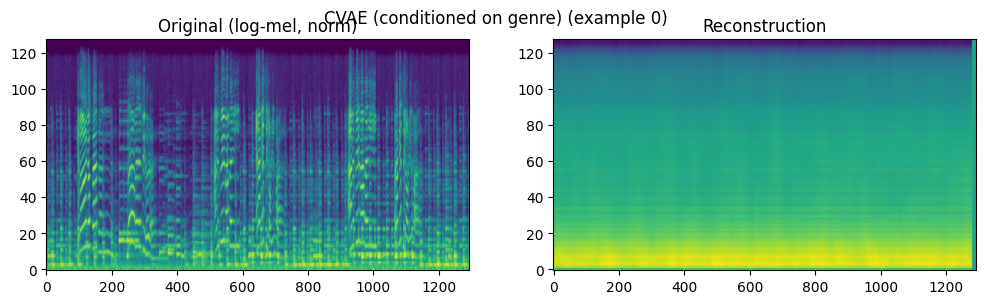

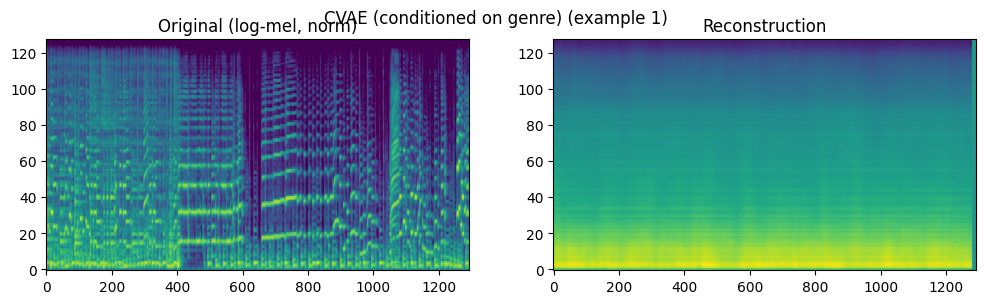

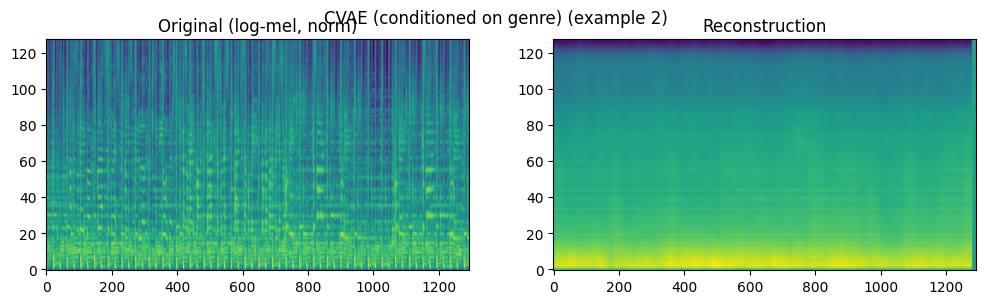

In [45]:
# ============================================
# CELL 11: Reconstruction examples (Hard requirement)
# ============================================
ae.eval(); bvae.eval(); cvae.eval()

sample_loader = DataLoader(
    MelCondDataset(val_paths[:6], val_y[:6], n_classes=N_CLASSES),
    batch_size=6, shuffle=False, num_workers=0
)
x, y, yoh = next(iter(sample_loader))
x = x.to(DEVICE)
yoh = yoh.to(DEVICE)

with torch.no_grad():
    xhat_ae, _ = ae(x)
    xhat_b, _, _ = bvae(x)
    xhat_c, _, _ = cvae(x, yoh)

def show_recon_grid(x, xhat, title, n=3):
    x = x.cpu().numpy()
    xhat = xhat.cpu().numpy()
    for i in range(min(n, x.shape[0])):
        plt.figure(figsize=(12,3))
        plt.suptitle(f"{title} (example {i})")
        plt.subplot(1,2,1)
        plt.imshow(x[i,0], aspect="auto", origin="lower")
        plt.title("Original (log-mel, norm)")
        plt.subplot(1,2,2)
        plt.imshow(xhat[i,0], aspect="auto", origin="lower")
        plt.title("Reconstruction")
        plt.show()

show_recon_grid(x, xhat_ae, "ConvAE")
show_recon_grid(x, xhat_b, f"BetaVAE (beta={BETA})")
show_recon_grid(x, xhat_c, "CVAE (conditioned on genre)")


In [46]:
# ============================================
# CELL 12: Quick interpretation helper (print best methods)
# ============================================
best_by_sil = df_res.sort_values("silhouette", ascending=False).head(3)
best_by_nmi = df_res.sort_values("NMI", ascending=False).head(3)
best_by_ari = df_res.sort_values("ARI", ascending=False).head(3)

print("Top by Silhouette:\n", best_by_sil[["rep","silhouette","davies","calinski"]], "\n")
print("Top by NMI:\n", best_by_nmi[["rep","NMI","ARI","purity"]], "\n")
print("Top by ARI:\n", best_by_ari[["rep","ARI","NMI","purity"]], "\n")


Top by Silhouette:
                                    rep  silhouette        davies      calinski
3      BetaVAE(beta=1.5) mu(16)+KMeans    0.998999  2.584482e-09  1.494111e+17
4  CVAE(condition=genre) mu(16)+KMeans    0.252354  1.158580e+00  7.558624e+02
1               PCA(10 on MFCC)+KMeans    0.183922  1.582785e+00  1.817997e+02 

Top by NMI:
                         rep       NMI       ARI    purity
1    PCA(10 on MFCC)+KMeans  0.306022  0.168308  0.371371
0       Raw MFCC(40)+KMeans  0.292920  0.156730  0.365365
2  ConvAE latent(16)+KMeans  0.174221  0.103541  0.318318 

Top by ARI:
                         rep       ARI       NMI    purity
1    PCA(10 on MFCC)+KMeans  0.168308  0.306022  0.371371
0       Raw MFCC(40)+KMeans  0.156730  0.292920  0.365365
2  ConvAE latent(16)+KMeans  0.103541  0.174221  0.318318 



In [47]:
# ============================================
# CELL 13: (Optional) Save cluster assignments for the best rep
# ============================================
best_rep = df_res.iloc[0]["rep"]
print("Best rep (by sorting):", best_rep)

def get_rep_matrix(rep_name):
    if rep_name == "Raw MFCC(40)+KMeans":
        return X_mfcc_z, ok_y, np.array(ok_paths)
    if rep_name == "PCA(10 on MFCC)+KMeans":
        return Xpca, ok_y, np.array(ok_paths)
    if "ConvAE" in rep_name:
        return StandardScaler().fit_transform(Z_ae), y_audio, np.array(good_paths)
    if "BetaVAE" in rep_name:
        return StandardScaler().fit_transform(Z_bvae), y_audio, np.array(good_paths)
    if "CVAE" in rep_name:
        return StandardScaler().fit_transform(Z_cvae), y_audio, np.array(good_paths)
    raise ValueError("Unknown rep")

Xbest, ybest, pbest = get_rep_matrix(best_rep)
km = KMeans(n_clusters=K, n_init=10, random_state=SEED).fit(Xbest)
pred = km.labels_

df_assign = pd.DataFrame({
    "path": pbest,
    "true_genre_id": ybest,
    "true_genre": [genre_names[i] for i in ybest],
    "cluster": pred
})

df_assign.to_csv("results_hard/best_rep_assignments.csv", index=False)
print("Saved: results_hard/best_rep_assignments.csv")
df_assign.head()


Best rep (by sorting): BetaVAE(beta=1.5) mu(16)+KMeans
Saved: results_hard/best_rep_assignments.csv


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


path  true_genre_id  \
0  /kaggle/input/gtzan-dataset-music-genre-classi...              1   
1  /kaggle/input/gtzan-dataset-music-genre-classi...              4   
2  /kaggle/input/gtzan-dataset-music-genre-classi...              4   
3  /kaggle/input/gtzan-dataset-music-genre-classi...              5   
4  /kaggle/input/gtzan-dataset-music-genre-classi...              9   

  true_genre  cluster  
0  classical        0  
1     hiphop        0  
2     hiphop        0  
3       jazz        0  
4       rock        0